In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.linear_model import Ridge

In [2]:
data = pd.read_csv("kc_house_data.csv")
#Load the data from the House Price Data CSV file

In [3]:
print("Number of records = ",data.shape[0])
print("Number of features = ", data.shape[1])
print("Number of incomplete fields = ", data.isna().sum())



Number of records =  21613
Number of features =  21
Number of incomplete fields =  id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


The dataset used for the model has 21613 samples, with 21 base features. Some of these features were removed and modified to create newer features, which will be computed in the following code cells. There were no incomplete fields in the dataset.
There is only one caterogical variable "waterfront" which already came binary encoded. So there was no need to preprocess and encode the values of the feature from our end.
The ID field was removed since it does not play any role as a feature in determining the price of a house.
The entries in the date field were not suitable for proper heavy preprocessing and standardization. Therefore, the feature was removed from the dataset, used to create new features (month, day, year) which were computed by subtracting the date in the feature from May 1st, 2014, since the dataset contains house prices from May 2014. This leads us to have 21 total features.
The histograms of all these features is computed in the next code cell, including the binary encoded categorical variables.

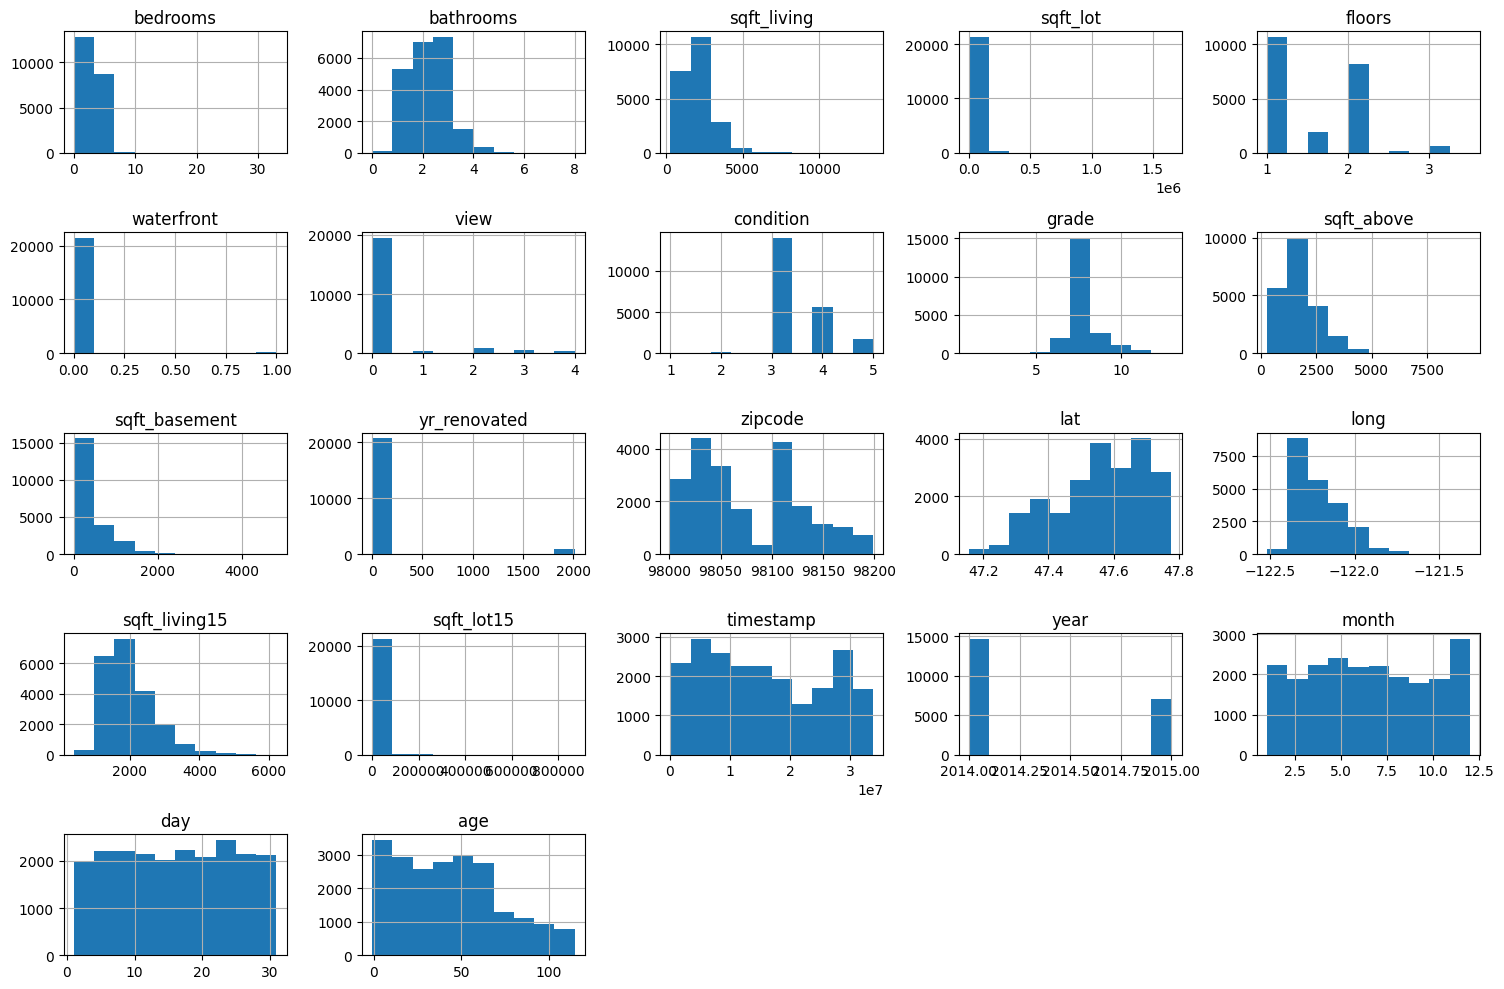

Number of records =  21613
Number of features =  22
Number of incomplete fields =  bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
timestamp        0
year             0
month            0
day              0
age              0
dtype: int64


In [8]:
## Feature Engineering ##

#Drop the insiginificant features: ID.
#Drop the date for better formatting for feature extracting
#Drop the price feature because it is the target variable.
Dataset = data.drop(['id', 'price', 'date', 'yr_built'], axis=1)

#House price is the target variable.
Target = data['price']


#Format the date properly to be the time passed since May 2014
data['date'] = pd.to_datetime(data['date'])
data['timestamp'] = (data['date'] - pd.Timestamp("2014-05-01")) // pd.Timedelta('1s')
Dataset['year'] = data['date'].dt.year

Dataset['month'] = data['date'].dt.month
Dataset['day'] = data['date'].dt.day

#Use the yr_built feature to compute the age of the house
Dataset['age'] = data['year'] - data['yr_built']

#Plot histograms of all variables
features = Dataset.columns[:28]
Dataset[features].hist(bins=10,figsize=(15,10))
plt.tight_layout()
plt.show()

print("Number of records = ",Dataset.shape[0])
print("Number of features = ", Dataset.shape[1])
print("Number of incomplete fields = ", Dataset.isna().sum())

In the next code cell, we initialize our Regression model. We use Least Squares Regression here since the number of samples is significantly greater than the number of features. We also wanted to test whether or not regularization will affect the predictions or not.
Since Least Squares Regression does not required any hyperparameters, We perform K fold cross validation with different K values.
We then find the best K value using the highest R2 score, and train the dataset based on that K value, using the best K folds.
The features are standardized while the Cross Validation is being performed, so that the data is original with every K value CV.
We compute the Root mean Squared error between the true values "the given house price" and the predicted house price.
We use sklearn's packahes here, including the R2 score in order to easily compute the R2 score of the model using parallel programming provided by the package.
For the model, we decided to fit the intercept since regardless of the features of the house, every house has a base price. In order to understand the growth of the prices based on the features, we needed to identify what values lead to the baseline cost of a house.
We also chose to use a copy of the training dataset since we do not want to change the dataset values, especially, the latitude and longitude and other sensitive float values, which could significantly alter the predictions.
Time complexity:
n = 21613
K = 5
Every fold = 21613/5 ~= 4000 samples
After every run: 20000 total samples processed.
O(n*p) since every feature (out of 21) is processed

Same for other k values:
=> O(k*n) = O(k*n*p)


In [9]:
LRRMSE = [] #Initialize array for Root Mean Squared Error
LRR2 = []  #Initialize array for R2 error
BestR2 = [0] #Initialize temporary array for the best R2 score
best_k = 0 #Initialize variable for the best k value for K fold cross validation

#Perform Linear Regression using K-fold Cross Validation
classifier1 = LinearRegression(fit_intercept=True, copy_X=True,)
k_folds = [5,8,10,12, 15]
for k in k_folds:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_set, test_set in kf.split(Dataset):
        train_samples, test_samples = Dataset.iloc[train_set], Dataset.iloc[test_set]
        train_labels, test_labels = Target.iloc[train_set], Target.iloc[test_set]
        scaler = StandardScaler()

        scaled_trainX = scaler.fit_transform(train_samples)
        scaled_testX = scaler.transform(test_samples)


        classifier1.fit(scaled_trainX, train_labels)
        LRPred = classifier1.predict(scaled_testX)
        rmse = np.sqrt(mean_squared_error(test_labels, LRPred))
        LRRMSE.append(rmse)
        r2 = r2_score(test_labels, LRPred)
        LRR2.append(r2)
        avRMSE = np.mean(LRRMSE)
        avR2 = np.mean(LRR2)
    print("for k: ", k, "folds:")
    print(f'Least Squares Regression Average Root Mean Sqaured Error: {avRMSE}')
    print(f'Least Squares Regression Average R2 Score: {avR2}')
    if avR2 > BestR2:
        best_k = k
        BestR2 = avR2
print(f"Best k value for K folds: {best_k} \n" )



for k:  5 folds:
Least Squares Regression Average Root Mean Sqaured Error: 200639.45434258925
Least Squares Regression Average R2 Score: 0.7007241831588503
for k:  8 folds:
Least Squares Regression Average Root Mean Sqaured Error: 200477.0559161619
Least Squares Regression Average R2 Score: 0.7006803018710512
for k:  10 folds:
Least Squares Regression Average Root Mean Sqaured Error: 200386.5120971809
Least Squares Regression Average R2 Score: 0.7008556112961762
for k:  12 folds:
Least Squares Regression Average Root Mean Sqaured Error: 200354.089321523
Least Squares Regression Average R2 Score: 0.7009022089370651
for k:  15 folds:
Least Squares Regression Average Root Mean Sqaured Error: 200288.00357020582
Least Squares Regression Average R2 Score: 0.7008548064723357
Best k value for K folds: 12 



Runnign time: O(12np) for k = 12 folds.

In [10]:
#Train Linear Regression model using the best K value = 12.
kf = KFold(n_splits=best_k, shuffle=True, random_state=42)
for train_set, test_set in kf.split(Dataset):
    train_samples, test_samples = Dataset.iloc[train_set], Dataset.iloc[test_set]
    train_labels, test_labels = Target.iloc[train_set], Target.iloc[test_set]

    #Standardize both the training and the test data.
    scaler = StandardScaler()
    scaled_trainX = scaler.fit_transform(train_samples)
    scaled_testX = scaler.transform(test_samples)

    #Train the model
    classifier1.fit(scaled_trainX, train_labels)

    #Test the model
    LRPred = classifier1.predict(scaled_testX)

    #Calculate the root mean squared error, T = number of samples = 21613
    rmse = np.sqrt(mean_squared_error(test_labels, LRPred))
    LRRMSE.append(rmse)

    #Calculate the R2 score where test labels = y_i and LRPred = y^
    r2 = r2_score(test_labels, LRPred)
    LRR2.append(r2)

#Calculate and display the average Root Mean Squared Error
#Calculate and display the average R2 score.
avRMSE = np.mean(LRRMSE)
avR2 = np.mean(LRR2)
print(f'Linear Regression Average Root Mean Squared Error: {avRMSE}')
print(f'Linear Regression Average R2 Score: {avR2}')

Linear Regression Average Root Mean Squared Error: 200288.7665569103
Linear Regression Average R2 Score: 0.7008812673645486


In the code cell below, we compute the scatter plot of the predictions vs actual data points.
The model is accurate if y = x, or in this scenario, the predicted values equal the actual values.
To visualize this, we plotted the line y = x.
Now it is observed that the trajectory of the scatter points follows the line, which means that the predictions are accurate.
This is also justified by the R2 score of 0.7 since as learned in the class, a good model has an R2 score between (0.5,1).

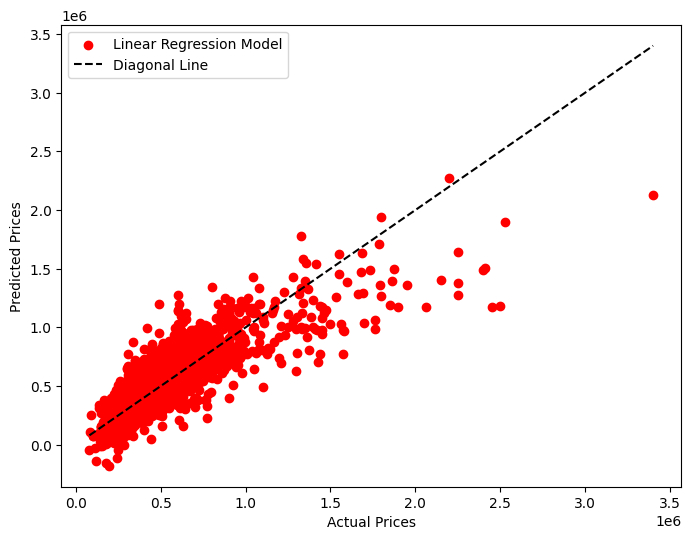

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(test_labels, LRPred, label='Linear Regression Model', c='r')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], linestyle='--', color='black', label='Diagonal Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

Now we perform ridge regression, which requires a hyperparameter. To be specific, Ridge Regression involves L2 regularization. For that, we need to find the perfect regularization paramater, lambda.
We use ridge regression here because it deals well with the outliers after the standardization, reducing the possibility of overfitting.
In scikit learn's RidgeRegression() package, the regularization parameter is given by alpha, which is equal to 1/2(lambda). Therefore, we accordingly decided to use the following range of alpha values for the regularization, ranging from strong (0.01-0.1) to weak(10-100).
Using these alpha values, we perform K fold cross validation with the same range of K values.
We then find the best K value as well as the best alpha value, which would be used to train the entire dataset.
The dataset is again standardized during the cross validation since we want the original data to be used for every validation run, with every K and alpha value.
Similar to OLS regression, we compute the Root mean square error, its average, he R2 score and its average to evaluate our model as well as find the best parameters.
Time complexity:
n = 21613
K = 5
Every fold = 21613/5 ~= 4000 samples
After every run: 20000 total samples processed.
O(n*p) since every feature (out of 21) is processed

Same for other k values:
=> O(k*n) = O(k*n*p)

This processing is done for every alpha value O(1):
=> O(1)*O(k*n*p) = O(knp)

In [12]:
#Set up Ridge Regression for K fold cross validation with different alpha and K values.
#alpha here is actually lambda λ, or the regularization parameter.
alpha_vals = [0.01,0.1,1,10,100]
best_alpha = 0
best_R2alpha = 0
for al in alpha_vals:
    Classifier2 = Ridge(fit_intercept=True, alpha=al, copy_X=True)
    RRMSE = []
    RRR2 = []
    best_k2 = 0
    BestR2_R = 0
    k_folds2 = [5,8,10,12, 15]
    print(f"for lambda = {al}:")
    for k in k_folds2:
        #Split the dataset during the K fold. 42 chosen for randomState so that the data split remains the same and
        #leads to reproducability of the model. Otherwise, the metrics and predictions would be different
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        for train_set, test_set in kf.split(Dataset):
            train_samples, test_samples = Dataset.iloc[train_set], Dataset.iloc[test_set]
            train_labels, test_labels = Target.iloc[train_set], Target.iloc[test_set]
            scaler2 = StandardScaler()

            scaled_trainX = scaler2.fit_transform(train_samples)
            scaled_testX = scaler2.transform(test_samples)

            Classifier2.fit(scaled_trainX, train_labels)
            RidgePred = Classifier2.predict(scaled_testX)

            RMSE = np.sqrt(mean_squared_error(test_labels, RidgePred))
            RRMSE.append(RMSE)

            R2 = r2_score(test_labels, RidgePred)
            RRR2.append(R2)

            RavRMSE = np.mean(RRMSE)
            RavR2 = np.mean(RRR2)

        print(f"for {k} folds:")

        print(f'Ridge Regression Average Root Mean Squared Error: {RavRMSE}')
        print(f'Ridge Regression Average R2 Score: {RavR2} \n')
        if RavR2 > BestR2_R:
            best_k2 = k
            BestR2_R = RavR2
    if RavR2 > best_R2alpha:
        best_alpha = al
        best_R2alpha = RavR2
print(f"Best alpha/lambda = {best_alpha}")
print(f"Best k value for K folds: {best_k2} \n" )


for lambda = 0.01:
for 5 folds:
Ridge Regression Average Root Mean Squared Error: 200639.76059316937
Ridge Regression Average R2 Score: 0.7007226627666544 

for 8 folds:
Ridge Regression Average Root Mean Squared Error: 200477.57641273917
Ridge Regression Average R2 Score: 0.7006783284437783 

for 10 folds:
Ridge Regression Average Root Mean Squared Error: 200387.1392246982
Ridge Regression Average R2 Score: 0.7008531141504151 

for 12 folds:
Ridge Regression Average Root Mean Squared Error: 200349.66683337273
Ridge Regression Average R2 Score: 0.7009152555363696 

for 15 folds:
Ridge Regression Average Root Mean Squared Error: 200285.12111291752
Ridge Regression Average R2 Score: 0.7008629180528064 

for lambda = 0.1:
for 5 folds:
Ridge Regression Average Root Mean Squared Error: 200663.75193492346
Ridge Regression Average R2 Score: 0.700647920438253 

for 8 folds:
Ridge Regression Average Root Mean Squared Error: 200500.04966414615
Ridge Regression Average R2 Score: 0.700608556542664

We now use the best parameters that we found, to train our model on the entire training dataset. After training, keeping the standardization in consideration, we test our model and evaluate the RMS errors and the R2 score.
Running time = O(1)*O(n*p)
=> O(n*p)

In [13]:
#Train Ridge Regression model with the best λ = 0.01, best k = 12
Classifier2 = Ridge(fit_intercept=True, alpha=best_alpha, copy_X=True)
RRMSE = []
RRR2 = []
#Split the dataset into K folds.
kf = KFold(n_splits=best_k2, shuffle=True, random_state=42)
for train_set, test_set in kf.split(Dataset):
    train_samples, test_samples = Dataset.iloc[train_set], Dataset.iloc[test_set]
    train_labels, test_labels = Target.iloc[train_set], Target.iloc[test_set]

    #Standardize the folds.
    scaler2 = StandardScaler()
    scaled_trainX = scaler2.fit_transform(train_samples)
    scaled_testX = scaler2.transform(test_samples)

    #Train the model
    Classifier2.fit(scaled_trainX, train_labels)

    #Test the model
    RidgePred = Classifier2.predict(scaled_testX)

    #Calculate the root mean squared error
    RMSE = np.sqrt(mean_squared_error(test_labels, RidgePred))
    RRMSE.append(RMSE)

    #Calculate the R2 score
    ridge_reg_r2 = r2_score(test_labels, RidgePred)
    RRR2.append(ridge_reg_r2)

    #Compute the average R2 score.
    RavRMSE = np.mean(RRMSE)
    RavR2 = np.mean(RRR2)

print(f'Ridge Regression Average Root Mean Squared Error: {RavRMSE}')
print(f'Ridge Regression Average R2 Score: {RavR2} \n')

Ridge Regression Average Root Mean Squared Error: 200277.84474999897
Ridge Regression Average R2 Score: 0.7010343598594488 



We now plot the predicted values vs real values on a scatter plot, referencing the line y = x, which corresponds to 100% accuracy of the model.

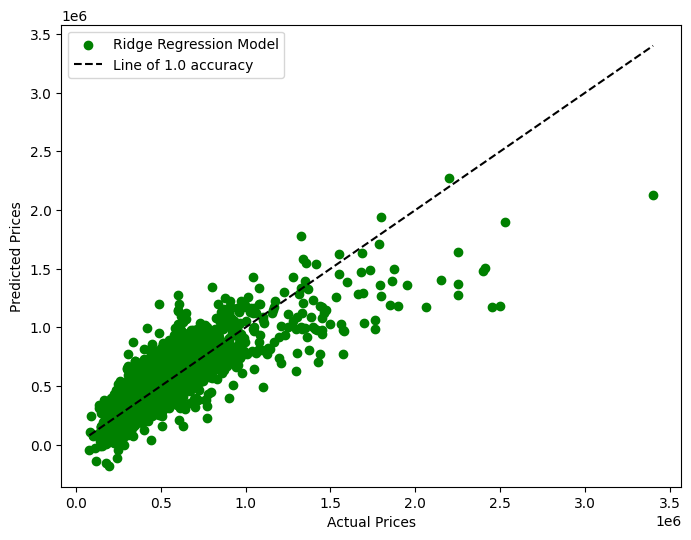

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(test_labels, RidgePred, label='Ridge Regression Model', c= 'g')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], linestyle='--', color='black', label='Line of 1.0 accuracy')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

For further conclusion, we plot the prediction vs actual scatter plots on the same figure to compare both the models. It can be seen that both the models provide precisely identical results.
This leads us to believe that regularizing the data will not play that significant of a role as we expected it to play.

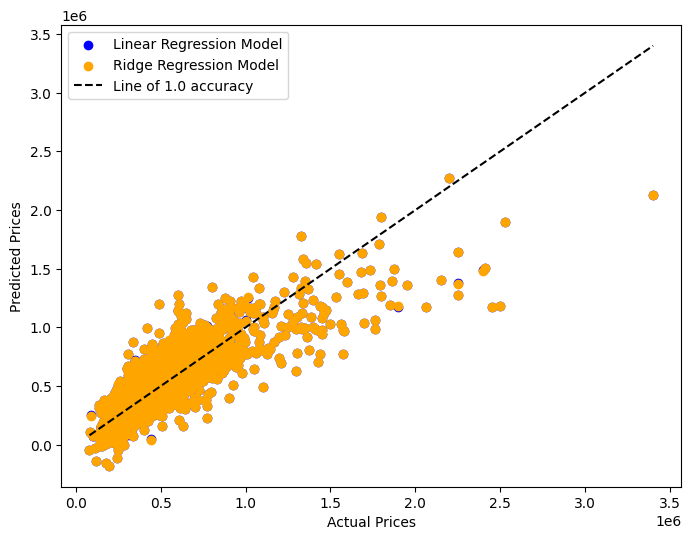

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(test_labels,LRPred, label='Linear Regression Model', c = 'b')
plt.scatter(test_labels, RidgePred, label='Ridge Regression Model', c= 'orange')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], linestyle='--', color='black', label='Line of 1.0 accuracy')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


After evaluating both our models, we come to conclusion that ridge regression should be used in production. This is because, although the model requires the additional computation of regularizind the dataset, it takes the same comptutational time when it comes to processing the data.
Moreover, ridge regression takes well care of outliers and seeing the plot we can say that outliers make up a significant portion of all data. This makes our model more robust.

Some of the ethical issues that revolve around regression for house price predictions are as follows:
1. House prices may be centered or distributed near specific neighborhoods. In other words, they may be clustered in those neighborhoods, and rising house prices may lead to ethnic communities living in those neighborhoods to leave the areas. Or, people who might be planning to acquire properties in those neighborhoods might avoid them after looking at the predictions, potentially causing ethnic discrimination due to the model.
2. Another ethic issue is situations analogous to gambling. People may purchase houses near areas at certain dates after looking at the model, and then check the predictions by the model to sell the property for profits, reducing opportunities for people to acquire affordable property on time.

**Bibliography**
For information on the parameters of Linear Regression:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

For information on RSS and the Linear regression line
https://statisticsbyjim.com/regression/least-squares-regression-line/

For metrics and use cases of Linear Regression
https://rutgers.instructure.com/courses/243699/files/36399133?module_item_id=9316674

For the difference between ridge and least squares regression
https://online.stat.psu.edu/stat857/node/155/

For parameters analysis of Scikit's RidgeRegression()
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

For python syntax and insights on feature engineering
https://chat.openai.com/